In [1]:
import os
import torch
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data_utils

#constant declaration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 30

In [3]:
# For full dataset, run tran_feature_selection notebook before this one
# For small subset of data, run tran_sample_preprocessing notebook beofore this one (ideal for testing model on CPU)

%store -r benign_flows  
%store -r mixed_flows
%store -r features

dim = len(features)

training = preprocessing.normalize(benign_flows[features])
train_data = pd.DataFrame(training, columns = features)
train_data.head(10)

,flowInd,duration,numHdrDesc,l4Proto,macPairs,dstPortClassN,numPktsSnt,numPktsRcvd,numBytesSnt,numBytesRcvd,...,connDip,connSipDip,connSipDprt,connF,aveIAT,maxIAT,stdIAT,tcpISeqN,tcpUtm,tcpWinSzThRt
0,0.977842,0.000000e+00,2.253185e-06,3.830415e-05,2.253185e-06,1.194188e-04,2.253185e-06,2.253185e-06,7.435511e-05,1.104061e-04,...,9.012741e-06,1.038944e-02,1.038493e-02,1.038493e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
1,0.948144,0.000000e+00,3.427481e-06,5.826717e-05,3.427481e-06,4.215801e-04,3.427481e-06,3.427481e-06,1.645191e-04,1.645191e-04,...,3.427481e-06,7.540457e-03,7.540457e-03,8.378284e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
2,0.999879,8.136645e-05,9.365147e-06,1.592075e-04,9.365147e-06,4.963528e-04,2.809544e-05,1.873029e-05,1.030166e-03,5.225752e-03,...,1.030166e-04,1.498424e-04,9.365147e-05,1.040572e-05,2.712215e-05,4.683897e-05,1.418111e-05,0.000000,0.000000,0.0
3,0.956680,0.000000e+00,3.139539e-06,5.337216e-05,3.139539e-06,1.663955e-04,3.139539e-06,3.139539e-06,1.036048e-04,1.538374e-04,...,9.418616e-06,6.950939e-03,6.944659e-03,6.313326e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
4,0.976209,0.000000e+00,3.304433e-06,5.617536e-05,3.304433e-06,1.751350e-04,3.304433e-06,3.304433e-06,1.619172e-04,1.090463e-04,...,2.973990e-05,7.286275e-03,7.279666e-03,3.639833e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
5,0.000007,6.900878e-11,4.682561e-10,2.809537e-09,4.682561e-10,3.746049e-08,9.365123e-10,1.873025e-09,0.000000e+00,0.000000e+00,...,4.214305e-09,1.404768e-09,1.404768e-09,1.404768e-09,3.450439e-11,6.900878e-11,2.439829e-11,0.671980,0.000772,0.0
6,0.000003,1.691417e-11,7.431532e-10,4.458919e-09,7.431532e-10,3.652821e-05,4.458919e-09,5.202072e-09,1.434286e-07,3.165832e-07,...,2.972613e-09,2.972613e-09,2.229459e-09,7.431532e-10,2.819027e-12,6.808026e-12,1.662347e-12,1.000000,0.000000,0.0
7,0.944703,0.000000e+00,3.536200e-06,6.011541e-05,3.536200e-06,1.874186e-04,3.536200e-06,3.536200e-06,1.166946e-04,2.157082e-04,...,1.060860e-05,7.875118e-03,7.868046e-03,7.868046e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
8,0.977156,0.000000e+00,3.238480e-06,5.505416e-05,3.238480e-06,3.983330e-04,3.238480e-06,3.238480e-06,1.554470e-04,1.554470e-04,...,2.914632e-05,6.376567e-03,6.376567e-03,6.376567e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0
9,0.000015,4.160219e-10,3.001454e-10,1.800872e-09,3.001454e-10,1.329644e-07,3.901890e-09,2.701308e-09,1.500727e-06,6.573184e-07,...,3.001454e-10,1.200582e-09,2.401163e-09,4.001937e-10,3.200168e-11,1.764984e-10,4.293075e-11,0.835014,0.000004,0.0


In [4]:
#dataset loading
train_tensor = torch.tensor(train_data.values.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = True)
train_tensor

tensor([[9.7784e-01, 0.0000e+00, 2.2532e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.4814e-01, 0.0000e+00, 3.4275e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.9988e-01, 8.1366e-05, 9.3651e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [9.8968e-01, 0.0000e+00, 1.5450e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.8959e-01, 0.0000e+00, 1.5490e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.9797e-01, 7.1653e-09, 2.6179e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=dim, out_features=int(dim/2))
        self.enc2 = nn.Linear(in_features=int(dim/2), out_features=int(dim/4))
        self.enc3 = nn.Linear(in_features=int(dim/4), out_features=int(dim/8))
        
        # decoder 
        self.dec1 = nn.Linear(in_features=int(dim/8), out_features=int(dim/4))
        self.dec2 = nn.Linear(in_features=int(dim/4), out_features=int(dim/2))
        self.dec3 = nn.Linear(in_features=int(dim/2), out_features=dim)
        
    def forward(self, x):
#         x = F.relu(self.enc1(x))
#         x = F.relu(self.enc2(x))
#         x = F.relu(self.enc3(x))
        
#         x = F.relu(self.dec1(x))
#         x = F.relu(self.dec2(x))
#         x = F.relu(self.dec3(x))
        
        #sigmoid activation
        x = torch.sigmoid(self.enc1(x))
        x = torch.sigmoid(self.enc2(x))
        x = torch.sigmoid(self.enc3(x))

        x = torch.sigmoid(self.dec1(x))
        x = torch.sigmoid(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


In [7]:
#Trainning model

loss_function = nn.BCELoss()  # Alternative loss functions - BCEWithLogitsLoss(), MSELoss()

train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for data in train_loader:
        input_data = data.to(device=device)
        optimizer.zero_grad()
        output = net(input_data).to(device=device)                # output is the reconstruced x 
        loss = loss_function(output,input_data).to(device=device) # input_data should be the target variable
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    
    if epoch % 5 == 0:
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
        epoch+1, NUM_EPOCHS, loss))
print("Completed training with final loss {:.3f}".format(train_loss[-1]))

Epoch 1 of 50, Train Loss: 0.041
Epoch 6 of 50, Train Loss: 0.022
Epoch 11 of 50, Train Loss: 0.020
Epoch 16 of 50, Train Loss: 0.018
Epoch 21 of 50, Train Loss: 0.018
Epoch 26 of 50, Train Loss: 0.018
Epoch 31 of 50, Train Loss: 0.018
Epoch 36 of 50, Train Loss: 0.018
Epoch 41 of 50, Train Loss: 0.017
Epoch 46 of 50, Train Loss: 0.017


[0.040547215029481075,
 0.040340118191747446,
 0.0342175305888602,
 0.02416713253427889,
 0.02280878340160607,
 0.0219877008052602,
 0.021162033486098998,
 0.02068445146760954,
 0.020406904657738395,
 0.0202363832564896,
 0.020127474866700194,
 0.020013243808055182,
 0.01980170224311113,
 0.01913739134287702,
 0.01846769560311698,
 0.018293684095381152,
 0.018187325861222313,
 0.01809533042682365,
 0.01800400532232335,
 0.017926202013744483,
 0.017863809583618138,
 0.017816407415495172,
 0.017781421138799398,
 0.01775340028174208,
 0.01773189649993725,
 0.01771228142075987,
 0.017694424412112143,
 0.017677417078044825,
 0.017661176435314185,
 0.01764951265642188,
 0.01763528829522042,
 0.017620976012586723,
 0.01760719777892182,
 0.01759331873112459,
 0.01757762963974644,
 0.01756153499174597,
 0.0175381102970727,
 0.01751119282820676,
 0.017476949570382077,
 0.017431738439457962,
 0.01738722091199898,
 0.017345996083603446,
 0.017303849969351977,
 0.017271843642201978,
 0.017250102228

Completed training with final loss 0.017


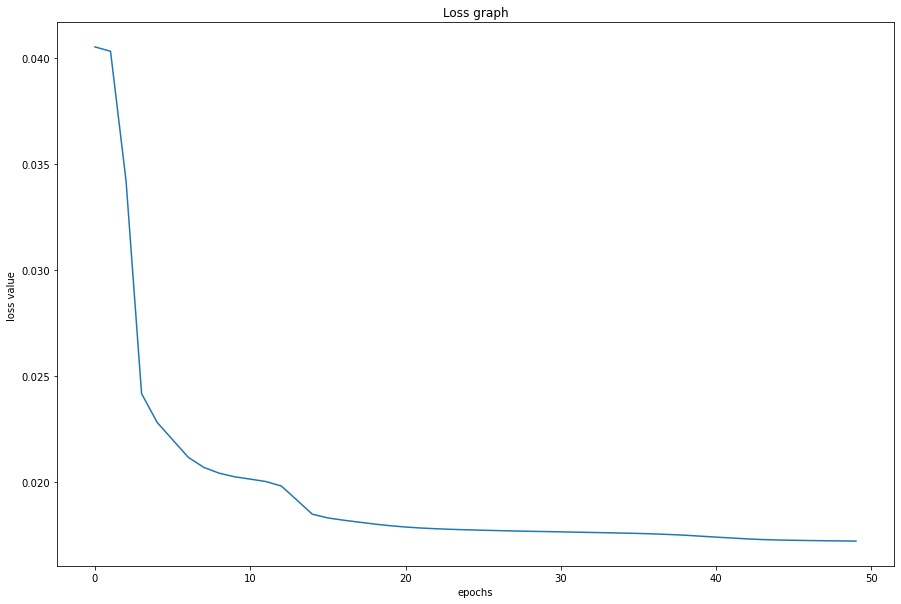

In [9]:
_, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel("epochs")
plt.ylabel("loss value ")
ax.set_title('Loss graph')
ax.plot(train_loss)

In [ ]:
#Prediction threshold 

# net.eval()

# loss_distr = []

# test_data = pd.read_csv("mixed_flows.csv", index_col=None, delimiter=',') # when loading from csv  

# # test_data = pd.DataFrame(mixed_flows)                                   # when loading from stored data

# for i in range(len(test_data)):
#     data = torch.from_numpy(np.array(test_data).float())
#     input_sample = net(data.to(device))
#     loss = loss_function(data.to(device), input_sample)
#     loss_distr.append(loss.item())

# loss_sc = []
# for i in loss_distr:
#     loss_sc.append((i,i))
# plt.scatter(*zip(*loss_sc))
# plt.axvline(0, 0, 1)
                            
    

In [ ]:
# lower_threshold = 0   #have to find the threshold
# upper_threshold = 0
# plt.figure(figsize=(15,20))
# plt.title('Loss Distribution')
# sns.distplot(loss_distr,bins=100,kde=True, color='blue')
# plt.axvline(upper_threshold, 0.0,10 , color='r')
# plt.axvline(lower_threshold, 0.0,10 , color='b')